In [8]:
# Get credentials
from IPython.utils import io
with io.capture_output() as captured:
    %run ../Introduction.ipynb
    
from datetime import datetime, timedelta
import math
import pandas as pd
from sentenai import Sentenai
sentenai = Sentenai(host=host, port=port)

# Introduction to TSPL

TSPL, short for **T**emporal **S**tream **P**rocessing **L**angugage, is Sentenai's primary tool for:

* Data Processing (Aggregation and Transformation)
* Data Fusion
* Pattern Recognition

Conceptually, TSPL is a human-readable stream description language that compiles down to an optimized stream processing program that targets the Tempest Stream Virtual Machine (TSVM), a Stream-oriented virtual machine that works similarly to the Java Virtual Machine (JVM).

Core to TSPL is composition, meaning that any valid TSPL program can be composed with other TSPL programs to generate transformation pipelines. This composability enables complex data fusion and pattern recognition tasks to be performed in real-time across historical and realtime data sets.
<div>
<img src="./TSVM.png" style="width: 400px; margin: 0 auto;"/>
</div>


## Setup: Creating some artificial data

In [9]:
data = []
for x in range(1000):
    data.append({
        "ts": datetime(2015, 1, 1) + timedelta(seconds=x),
        'a': math.sin(x / 100.),
        'b': math.cos(3 * x / 100.),
        'c': math.cos(x / 100.),
        'd': math.sin(x / 20.),
    })
df = pd.DataFrame(data)

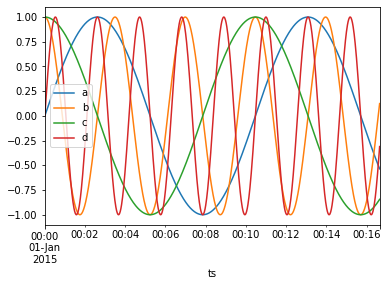

In [11]:
df.plot(x="ts", y=["a", "b", "c", "d"]);

In [25]:
sig = sentenai.init("signals", origin=datetime(2015,1,1))

Exception: Could not initialize

In [15]:
for x in data:
    sig.log[x.pop("ts"):] = x

## Basic Data Retrieval

To use TSPL with the sentenai client, we call the client object with a TSPL statement. The simplest statement just references a database and stream. We use `/` to specify a path. There will always be at least one `/` to separate a stream database from event and value streams it contains.


In [19]:
tspl = sentenai("signals/a")
print(tspl)

signals/a


The TSPL object we just created doesn't do anything on its own. Much like the `.data` object, we have to slice it, supplying `[start : end : limit]` all of which are optional parameters.

In [23]:
tspl[::2]

[{'start': numpy.datetime64('2015-01-01T00:00:00'),
  'value': 0,
  'end': numpy.datetime64('2015-01-01T00:00:01')},
 {'start': numpy.datetime64('2015-01-01T00:00:01'),
  'value': 0.009999833,
  'end': numpy.datetime64('2015-01-01T00:00:02')}]

Results are returned in the same form as the `.data` endpoints for streams.

If we want to directly pull out dataframes instead, we can use a shortcut:

In [24]:
sentenai.df("signals/a")[::2]

,start,end,duration,value
0,2015-01-01 00:00:00,2015-01-01 00:00:01,0 days 00:00:01,0.00
1,2015-01-01 00:00:01,2015-01-01 00:00:02,0 days 00:00:01,0.01


## Projecting a value stream onto an event stream

In addition to raw data retrieval, we can project that data onto an event stream:

In [26]:
sentenai.df("mean(signals/a) when frequency(2s)")[::2]

,start,end,duration,value
0,2015-01-01 00:00:00,2015-01-01 00:00:02,0 days 00:00:02,0.005000
1,2015-01-01 00:00:02,2015-01-01 00:00:04,0 days 00:00:02,0.024997


This introduces the `when` keyword. `when` is used to specify the target event stream we'd like to project onto. In this case we're using a generator of periods, the function `frequency`. Periods support similar notation to Pandas, down to nanosecond precision. The largest unit currently supported is weeks (`w`).

In addition to event stream generators like `frequency`, any event stream, either stored in a stream database or calculated via event processing, can be used as a source:

In [28]:
sentenai.df("max(signals/a) when signals/b > 0.0")[::2]

,start,end,duration,value
0,2015-01-01 00:00:00,2015-01-01 00:00:53,0 days 00:00:53,0.496880
1,2015-01-01 00:02:38,2015-01-01 00:04:22,0 days 00:01:44,0.999958


This example introduces basic conditional interval generation. We take `signals/b` and generate a new event stream consisting of time intervals where the value of the stream is `> 0`. We then project `signals/a` onto these events, using the `max()` aggregation function to select the maximum value present in each event interval.